In [51]:
import pandas as pd

In [52]:
retail = pd.read_excel('online_retail_II.xlsx')

In [53]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [54]:
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [55]:
# 1. Data Cleaning:

retail.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

**Handle missing values (especially CustomerID and Description)**

In [56]:
# Since each product has a unique product code
# we can search the database and replace the missing description with the product which has the same product code

def fillDescription(col):

  code = col[0]
  description = col[1]

  if pd.isnull(description):

    for item in zip(retail['StockCode'],retail['Description']):

      if item[0] == code:

        return item[1]

  return description

In [57]:
retail['Description'] = retail[['StockCode','Description']].apply(fillDescription,axis=1)


/tmp/ipykernel_32894/355091157.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  code = col[0]
/tmp/ipykernel_32894/355091157.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  description = col[1]


In [58]:
retail.isnull().sum()

Invoice             0
StockCode           0
Description       583
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [59]:
# BEST CASE WE CAN FILL THE CUSTOMER ID WITH UNKNOWN
# ESTIMATING WILL CAUSE UNWANTED RESULTS
retail['Customer ID'] = retail['Customer ID'].fillna(-1)

retail.isnull().sum()

Invoice          0
StockCode        0
Description    583
Quantity         0
InvoiceDate      0
Price            0
Customer ID      0
Country          0
dtype: int64

In [60]:
# droping na and duplicate rows

retail = retail.dropna().drop_duplicates()
retail.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
# Handle canceled orders (where InvoiceNo starts with 'C')
# handling with 'quantity' column because many cancelled oredrs are not starting with 'C'
# Splitting data into fullfilled and cancelled orders
# so we can analyze the cancelled data if needed

a = [x<0 for x in retail['Quantity'] ]
canc_orders = retail[a]
retail = retail[[not x for x in a]]

In [62]:
canc_orders.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [72]:
# Remove or cap outliers in Quantity and UnitPrice

import seaborn as sns

quantity = retail['Quantity']

Q1 = quantity.quantile(0.25)
Q3 = quantity.quantile(0.75)
med = quantity.median()

IQR = Q3-Q1
lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)

print(lower_bound,upper_bound)

-15.5 28.5


In [84]:
# Now that we have upper and lower bound we can cap the exceeding values
# not removing them since that will cause a lot of data loss

retail['Quantity'] = retail['Quantity'].clip(lower=lower_bound,upper=upper_bound)
# confirming that we limited the quantity

print(retail[retail['Quantity']> upper_bound].shape)
print(retail[retail['Quantity']< lower_bound].shape)

(0, 8)
(0, 8)


In [87]:
retail.to_excel('retail_clean.xlsx')

In [88]:
# Now that we have complete and clean data we ca start
# Exploratory Data Analysis (EDA)

# How many unique products are there
# can either find from stock code or description

unique_products = retail['StockCode'].unique()
print(f'No of unique products: {len(unique_products)}')

No of unique products: 4256


In [ ]:
# What is the total number of transactions

# total transaction can be calculated with uniique invoices

unique_trans = retail['Invoice'].unique()

print(f"Total transaction: {len(unique_trans)}")

Total transaction: 21908


In [99]:
# What countries do the customers belong to

countries = retail['Country'].unique()
countries

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Denmark', 'Netherlands', 'Poland',
       'Channel Islands', 'Spain', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland', 'Italy',
       'Switzerland', 'Japan', 'Unspecified', 'Nigeria', 'Malta',
       'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore', 'Thailand',
       'Israel', 'Lithuania', 'West Indies', 'Lebanon', 'Korea', 'Brazil',
       'Canada', 'Iceland'], dtype=object)

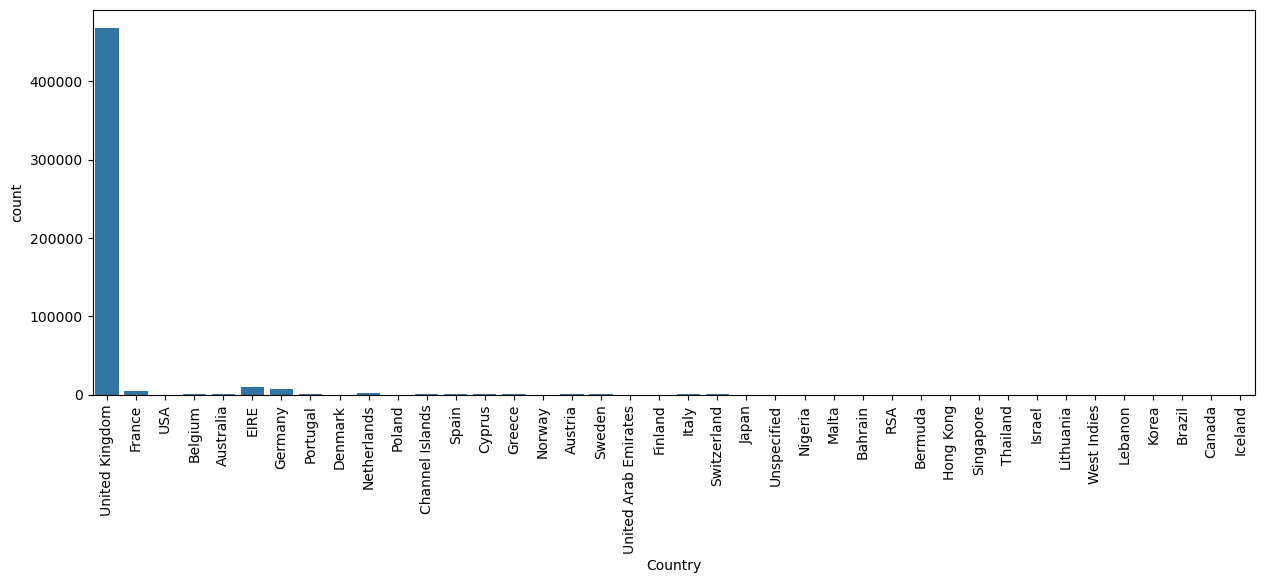

In [100]:
c_plot = sns.countplot(x='Country',data=retail)
c_plot.figure.set_size_inches(15,5)
c_plot.tick_params(axis='x',rotation=90)

In [124]:
# Product Analysis:

# top 10 selling products by quantity

top_10_sell = retail['Description'].value_counts().sort_values(ascending=False).head(10)
top_10_sell

Description
WHITE HANGING HEART T-LIGHT HOLDER    3410
REGENCY CAKESTAND 3 TIER              2036
STRAWBERRY CERAMIC TRINKET BOX        1679
ASSORTED COLOUR BIRD ORNAMENT         1436
PACK OF 72 RETRO SPOT CAKE CASES      1435
60 TEATIME FAIRY CAKE CASES           1372
HOME BUILDING BLOCK WORD              1349
JUMBO BAG RED RETROSPOT               1271
LUNCH BAG RED SPOTTY                  1231
JUMBO STORAGE BAG SUKI                1194
Name: count, dtype: int64

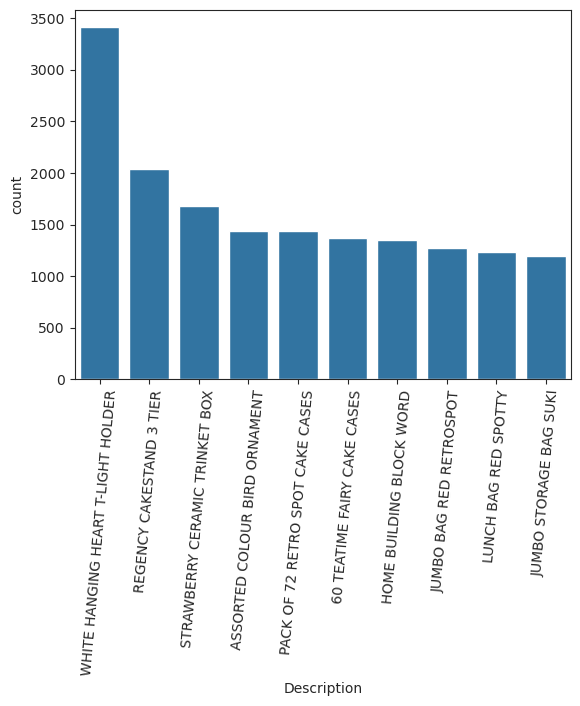

In [125]:
top_products = sns.countplot(x='Description',data=retail,order=top_10_sell.index)
top_products.tick_params(axis='x',rotation=85)

<AxesSubplot: xlabel='Description', ylabel='count'>

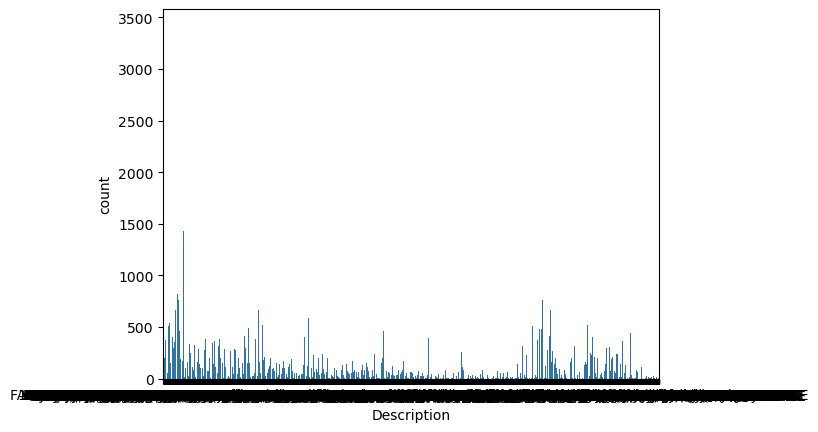

In [106]:
sns.countplot(x='Description',data=retail)